In [1]:
from recomenders import SLIM, ItemBasedCF, PureSVD
from movielens_dataset import *
from evaluation import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_1_M = get_1M_movielens()
data_100k = get_100K_movilens()

La BD has 1000209 ratings
La BD has  6040  users
La BD has  3706  movies
La BD has 100000 ratings
La BD has  943  users
La BD has  1682  movies


# Hit Rate metric
Metric extracted from paper "SLIM: Sparse Linear Methods"

### SLIM
First, I will anlyse the hit rate performance of SLIM model according to the value N and the original rate.

In [22]:
loocv = 1
hits_rate_list = []

print("Prepare data")
data_train, data_test = split_train_val_by_user(data_1_M, assign_=assign_loocv)
user_item = get_user_item(data_train)

Prepare data
Total movies 3706
Filtered movies  3043
(989452, 5)
(6040, 5)
Users: 6040
Movies: 3043


In [24]:
slim = SLIM()
print("Train")
slim.fit(user_item)

Train
Training for item  500
loss  0.3633221891820029
Training for item  1000
loss  0.4563641910681005
Training for item  1500
loss  0.4201124713889176
Training for item  2000
loss  0.3995642751734988
Training for item  2500
loss  0.3971259229478295
Training for item  3000
loss  0.38192355197299516


In [25]:
hit_rate(slim, data_test)

,rate,hits,qty,hit_rate
0,1,19,311,0.061093
1,2,52,581,0.089501
2,3,201,1421,0.141450
3,4,502,2083,0.240999
4,5,620,1644,0.377129


In [26]:
print("Evaluate")
top_N = slim.all_useres_recomendation(N=25)
hits_rate_list = []
for n in range(5,30,5):
    hits = hit_rate(slim, data_test,top_N=top_N[:,:n])
    hits["N"] = n
    hits_rate_list.append(hits)
hits_slim_df = pd.concat(hits_rate_list)

Evaluate


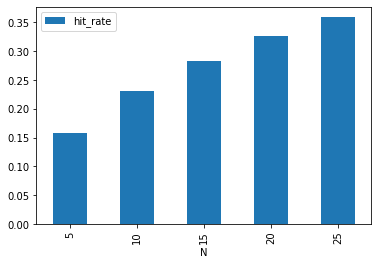

In [27]:
grouped_by_N = hits_slim_df.groupby("N").agg({"hits":"sum", "qty":"sum"})
grouped_by_N["hit_rate"] =  grouped_by_N["hits"]/grouped_by_N["qty"]
grouped_by_N.plot.bar(y="hit_rate")

<Figure size 720x576 with 0 Axes>

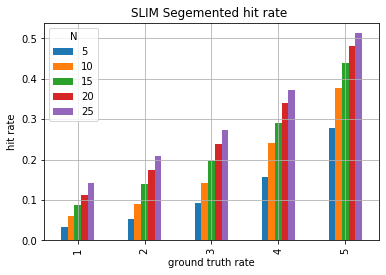

In [39]:
plt.figure(figsize=(10,8))
hits_slim_df.pivot("rate", "N", "hit_rate").plot(kind='bar')
plt.xlabel("ground truth rate")
plt.ylabel("hit rate")
plt.title("SLIM Segemented hit rate ")
plt.grid()
plt.savefig("./images/slim_segmented_hr.png")

### PureSvd

The paper "Performance of Recomender Algorithms" sugest a model called PureSvd that basically exploits the sparcity of the user matrix to efficiently compute a SVD factorization. Following I evaluate and compare hit rate performances with SLIM.

In [31]:
pure_svd = PureSVD(latent_factors=40)
print("Train")
pure_svd.fit(user_item)

Train


In [32]:
print("Evaluate")
top_N = pure_svd.all_useres_recomendation(N=25)
hits_rate_list = []
for n in range(5,30,5):
    hits = hit_rate(pure_svd, data_test,top_N=top_N[:,:n])
    hits["N"] = n
    hits_rate_list.append(hits)
hits_pure_svd_df = pd.concat(hits_rate_list)

Evaluate


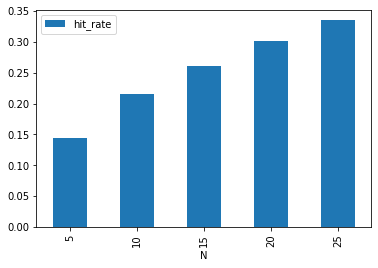

In [55]:
grouped_by_N = hits_pure_svd_df.groupby("N").agg({"hits":"sum", "qty":"sum"})
grouped_by_N["hit_rate"] =  grouped_by_N["hits"]/grouped_by_N["qty"]
grouped_by_N.plot.bar(y="hit_rate")

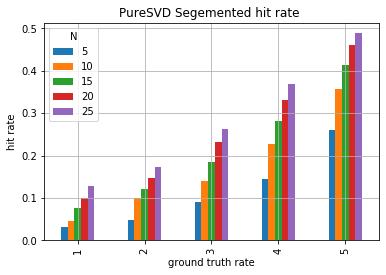

In [40]:
hits_pure_svd_df.pivot("rate", "N", "hit_rate").plot(kind='bar')
plt.xlabel("ground truth rate")
plt.ylabel("hit rate")
plt.title("PureSVD Segemented hit rate ")
plt.grid()
plt.savefig("./images/pure_svd_segmented_hr.png")

Comparision with SLIM model.

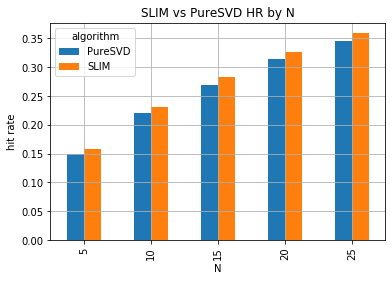

In [42]:
hits_slim_df["algorithm"] = "SLIM"
hits_pure_svd_df["algorithm"] = "PureSVD"
df = pd.concat((hits_slim_df, hits_pure_svd_df))
grouped_by_N = df.groupby(["N", "algorithm"]).agg({"hits":"sum", "qty":"sum"})
grouped_by_N["hit_rate"] =  grouped_by_N["hits"]/grouped_by_N["qty"]
grouped_by_N = grouped_by_N.reset_index()
grouped_by_N.pivot("N", "algorithm", "hit_rate").plot(kind='bar')
plt.grid()
plt.ylabel("hit rate")
plt.title("SLIM vs PureSVD HR by N")
plt.savefig("./images/svd_slim_comp.png")

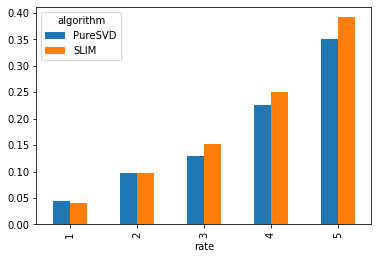

In [58]:
df[df.N == 10].pivot("rate", "algorithm", "hit_rate").plot(kind='bar')

In [43]:
df[df.N == 10]

,rate,hits,qty,hit_rate,N,algorithm
0,1,19,311,0.061093,10,SLIM
1,2,52,581,0.089501,10,SLIM
2,3,201,1421,0.141450,10,SLIM
3,4,502,2083,0.240999,10,SLIM
4,5,620,1644,0.377129,10,SLIM
0,1,14,311,0.045016,10,PureSVD
1,2,58,581,0.099828,10,PureSVD
2,3,198,1421,0.139338,10,PureSVD
3,4,476,2083,0.228517,10,PureSVD
4,5,586,1644,0.356448,10,PureSVD


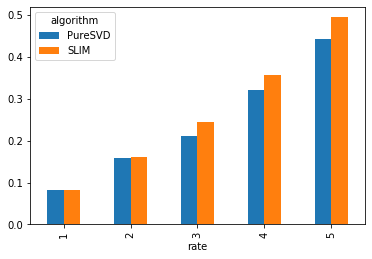

In [59]:
df[df.N == 20].pivot("rate", "algorithm", "hit_rate").plot(kind='bar')

### Item-based
Following is the hit rate analysis of item-based knn model. It uses a smaller dataset in order to accelerate the evaluation.

In [7]:
loocv = 1
hits_rate_list_knn = []
print("Prepare data")
data_train, data_test = split_train_val_by_user(data_100k, assign_=assign_loocv)
user_item = get_user_item(data_train)
knn = ItemBasedCF(knei=40)
print("Train")
knn.fit(data_train)

Prepare data
Total movies 1682
Filtered movies  939
(94025, 8)
(943, 8)
Users: 943
Movies: 939
Train


In [8]:
print("Evaluate")
top_N = knn.all_useres_recomendation(N=25)
for n in range(5,30,5):
    hits = hit_rate(knn, data_test,top_N=top_N[:,:n])
    hits["N"] = n
    hits_rate_list_knn.append(hits)
hits_knn_df = pd.concat(hits_rate_list_knn)
hits_knn_df

Evaluate


,rate,hits,qty,hit_rate,N
0,1,0,58,0.000000,5
1,2,0,90,0.000000,5
2,3,1,247,0.004049,5
3,4,5,310,0.016129,5
4,5,14,238,0.058824,5
0,1,0,58,0.000000,10
1,2,0,90,0.000000,10
2,3,2,247,0.008097,10
3,4,7,310,0.022581,10
4,5,20,238,0.084034,10


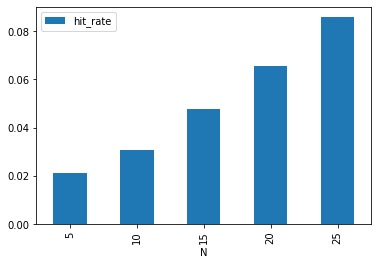

In [9]:
grouped_by_N = hits_knn_df.groupby("N").agg({"hits":"sum", "qty":"sum"})
grouped_by_N["hit_rate"] =  grouped_by_N["hits"]/grouped_by_N["qty"]
grouped_by_N.plot.bar(y="hit_rate")

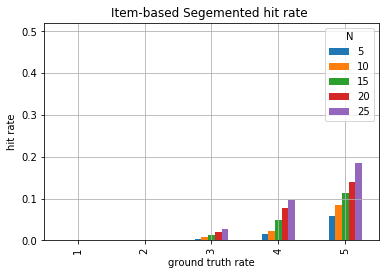

In [13]:
hits_knn_df.pivot("rate", "N", "hit_rate").plot(kind='bar')
plt.ylim((0,0.52))
plt.xlabel("ground truth rate")
plt.ylabel("hit rate")
plt.title("Item-based Segemented hit rate ")
plt.grid()
plt.savefig("./images/item_based_segmented_hr.png")

Due to restrictions of resourses and time, I will compare the SLIM algorithm with respect to the knn item-based algorithm in the 100K Movielens dataset.

In [14]:
loocv = 1
hits_rate_list = []

print("Prepare data")
user_item = get_user_item(data_train)
slim = SLIM()
print("Train")
slim.fit(user_item)

print("Evaluate")
top_N = slim.all_useres_recomendation(N=25)
for n in range(5,30,5):
    hits = hit_rate(slim, data_test,top_N=top_N[:,:n])
    hits["N"] = n
    hits_rate_list.append(hits)
hits_slim_df = pd.concat(hits_rate_list)

Prepare data
Train
Training for item  500
loss  0.8199115968880615
Evaluate


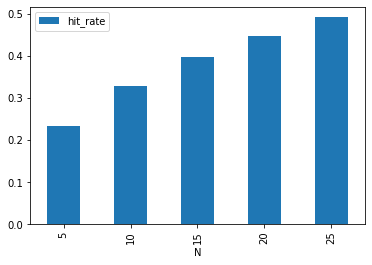

In [15]:
grouped_by_N = hits_slim_df.groupby("N").agg({"hits":"sum", "qty":"sum"})
grouped_by_N["hit_rate"] =  grouped_by_N["hits"]/grouped_by_N["qty"]
grouped_by_N.plot.bar(y="hit_rate")

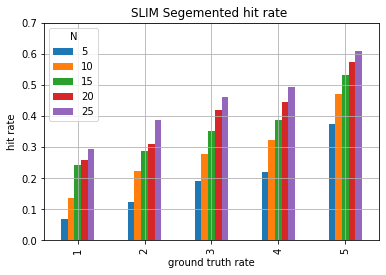

In [17]:
hits_slim_df.pivot("rate", "N", "hit_rate").plot(kind='bar')
plt.ylim((0,0.7))
plt.xlabel("ground truth rate")
plt.ylabel("hit rate")
plt.title("SLIM Segemented hit rate ")
plt.grid()
plt.savefig("./images/slim_smaller_segmented_hr.png")

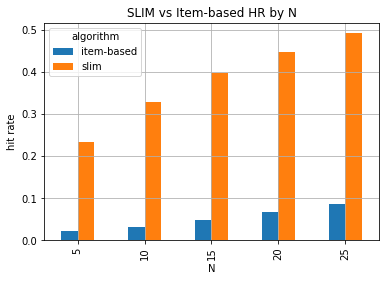

In [19]:
hits_slim_df["algorithm"] = "slim"
hits_knn_df["algorithm"] = "item-based"
df = pd.concat((hits_slim_df,hits_knn_df))
grouped_by_N = df.groupby(["N","algorithm"]).agg({"hits":"sum", "qty":"sum"})
grouped_by_N["hit_rate"] =  grouped_by_N["hits"]/grouped_by_N["qty"]
grouped_by_N = grouped_by_N.reset_index()
grouped_by_N.pivot("N", "algorithm", "hit_rate").plot(kind='bar')
plt.grid()
plt.ylabel("hit rate")
plt.title("SLIM vs Item-based HR by N")
plt.savefig("./images/item_based_slim_comp.png")

# Precision/recall metrics
Metrics are basen on the paper "Performance of Recomender Algorithms". Principaly, I will anlayse the SLIM and PureSVD algorithms on the 1M MovieLens dataset, in order to see different precision/recall values on different splits of the test set. For that reason I split the dataset according to the paper: data_train, data_test that contains only 5 star raitings (1.4% of the whole dataset, where only 5 stars raitings are selected), T_head that are only popular subset of data_test and T_long that are the not popular subdataset of data_test

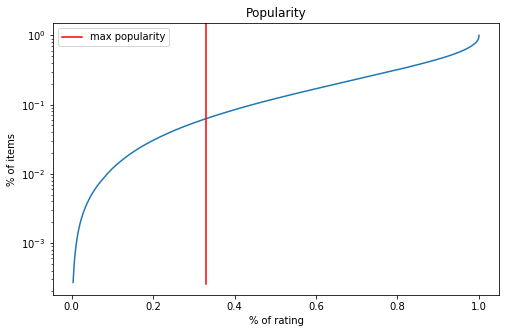

In [3]:
ordered_popularity = data_1_M.groupby("movie_id").agg({"rating": "count"}).sort_values(by="rating", ascending=False)
total = ordered_popularity.rating.sum()
ordered_popularity["rating_percent"] = ordered_popularity.rating / total
ordered_popularity["rating_percent_acum"] = np.cumsum(ordered_popularity.rating_percent.to_numpy())
total_movies = len(ordered_popularity.index)
ordered_popularity["movie_percent"] = 1 / total_movies
ordered_popularity["movies_percent_acum"] = np.cumsum(ordered_popularity.movie_percent.to_numpy())
plt.figure(figsize=(8,5))
plt.plot(ordered_popularity.rating_percent_acum, ordered_popularity.movies_percent_acum)
plt.yscale("log")
plt.title("Popularity")
plt.xlabel("% of rating")
plt.ylabel("% of items")
plt.axvline(x=0.33, ymin=0.04, ymax=1, c="red", label="max popularity")
plt.legend()

In [4]:
data_train, data_test,T_head, T_long = precision_recall_split(data_1_M)
user_item = get_user_item(data_train)

Filtered movies  3043


### SLIM

In [5]:
slim = SLIM()
slim.fit(user_item)

Training for item  500
loss  0.36402633019014824
Training for item  1000
loss  0.457856722604611
Training for item  1500
loss  0.42137221422765725
Training for item  2000
loss  0.40052841131328815
Training for item  2500
loss  0.39800511327002464
Training for item  3000
loss  0.38265801011324085


In [15]:
import pdb
selection=1000
N=10
movie_columns = slim.user_item.columns
ratings = slim.sparse_user_item * slim.W.T 

top_N = []

max_score = ratings.data.max() * np.ones(slim.sparse_user_item.nnz)
elim_matrix = slim.sparse_user_item.copy()
elim_matrix.data = max_score

ratings = ratings - elim_matrix # set to rating<0 to the movies that are already rated
for i,row in data_test.iterrows():
    u = row["user_id"]
    m = row["movie_id"]
    ui, = np.where(slim.user_item.index==u)
    r = ratings[ui,:]
    selected_list = np.array([ movie_columns[i] for v,i in sorted(zip(r.data,r.indices),reverse=True) if v > 0 or movie_columns[i] == m])
    idx = np.random.permutation(len(selected_list))[:selection]
    mi, = np.where(selected_list==m)
    if len(mi)>0 and not mi[0] in idx: idx = np.concatenate((idx, mi))
    idx = sorted(idx)
    selected_list = selected_list[idx][:N]
    top_N.append(selected_list)
np.array(top_N)

array([[  34, 2917, 3362, ..., 1960, 3702,  954],
       [1221,  750, 1244, ...,  930, 3467, 2186],
       [1240, 3471, 1199, ..., 2657, 1653, 2528],
       ...,
       [ 339,  745, 2485, ..., 1210,  708,  260],
       [1250, 2289,  926, ...,  909, 1132, 1233],
       [2174, 1977,  110, ..., 1198, 1200,  799]])

In [9]:
N_max=25
top_N_slim_data_test = slim.all_useres_recomendation_precision_recall(data_test=data_test, N=N_max)
top_N_slim_T_head = slim.all_useres_recomendation_precision_recall(data_test=T_head, N=N_max)
top_N_slim_T_long = slim.all_useres_recomendation_precision_recall(data_test=T_long, N=N_max)

acum_recall_data_test_slim, acum_precision_data_test_slim = compute_precision_recall_by_N(slim, top_N_slim_data_test, data_test)
acum_recall_T_head_slim, acum_precision_T_head_slim = compute_precision_recall_by_N(slim, top_N_slim_T_head, T_head)
acum_recall_T_long_slim, acum_precision_T_long_slim = compute_precision_recall_by_N(slim, top_N_slim_T_long, T_long)

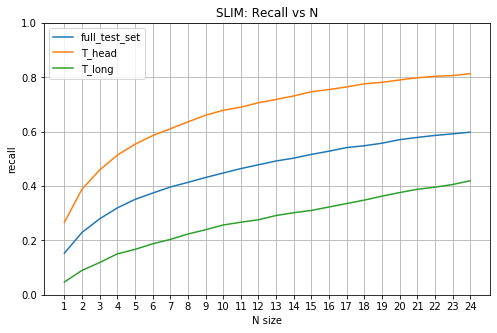

In [12]:
N_range = range(1,N_max)
plt.figure(figsize=(8,5))
plt.plot(N_range, acum_recall_data_test_slim, label="full_test_set")
plt.plot(N_range, acum_recall_T_head_slim, label="T_head")
plt.plot(N_range, acum_recall_T_long_slim, label="T_long")
plt.xticks(N_range)
plt.xlabel("N size")
plt.ylabel("recall")
plt.legend()
plt.title("SLIM: Recall vs N")
plt.ylim((0, 1))
plt.grid()
plt.savefig("./images/slim_recall.png")

In [14]:
acum_recall_data_test_slim[11]

0.47833014659018486

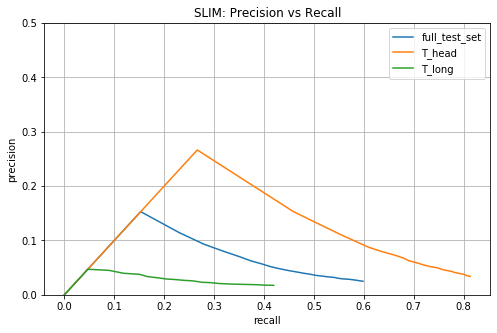

In [17]:
plt.figure(figsize=(8,5))
plt.plot([0]+acum_recall_data_test_slim, [0]+acum_precision_data_test_slim, label="full_test_set")
plt.plot([0]+acum_recall_T_head_slim, [0]+acum_precision_T_head_slim, label="T_head")
plt.plot([0]+acum_recall_T_long_slim, [0]+acum_precision_T_long_slim, label="T_long")
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend()
plt.title("SLIM: Precision vs Recall")
plt.ylim((0, 0.5))
plt.grid()
plt.savefig("./images/slim_prec_recall.png")

### PureSVD

In [9]:
pure_svd = PureSVD(latent_factors=50)
pure_svd.fit(user_item)

In [10]:
N_max = 25
top_N_pure_svd_data_test = pure_svd.all_useres_recomendation_precision_recall(data_test=data_test, N=N_max)
top_N_pure_svd_T_head = pure_svd.all_useres_recomendation_precision_recall(data_test=T_head, N=N_max)
top_N_pure_svd_T_long = pure_svd.all_useres_recomendation_precision_recall(data_test=T_long, N=N_max)

acum_recall_data_test_pure_svd, acum_precision_data_test_pure_svd = compute_precision_recall_by_N(pure_svd, top_N_pure_svd_data_test, data_test)
acum_recall_T_head_pure_svd, acum_precision_T_head_pure_svd = compute_precision_recall_by_N(pure_svd, top_N_pure_svd_T_head, T_head)
acum_recall_T_long_pure_svd, acum_precision_T_long_pure_svd = compute_precision_recall_by_N(pure_svd, top_N_pure_svd_T_long, T_long)

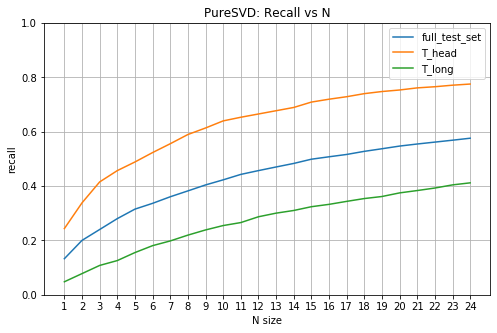

In [11]:
N_range = range(1,N_max)
plt.figure(figsize=(8,5))
plt.plot(N_range, acum_recall_data_test_pure_svd, label="full_test_set")
plt.plot(N_range, acum_recall_T_head_pure_svd, label="T_head")
plt.plot(N_range, acum_recall_T_long_pure_svd, label="T_long")
plt.xticks(N_range)
plt.xlabel("N size")
plt.ylabel("recall")
plt.legend()
plt.title("PureSVD: Recall vs N")
plt.ylim((0, 1))
plt.grid()
plt.savefig("./images/pure_svd_recall.png")

In [9]:
acum_recall_data_test_pure_svd[11]

0.26501100282929896

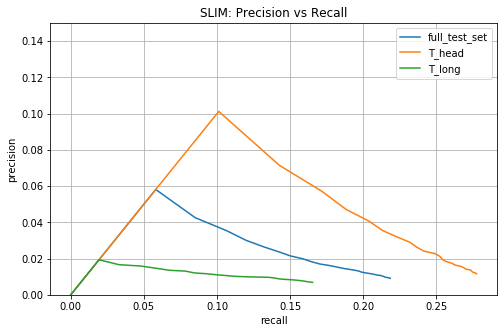

In [40]:
plt.figure(figsize=(8,5))
plt.plot([0]+acum_recall_data_test_pure_svd, [0]+acum_precision_data_test_pure_svd, label="full_test_set")
plt.plot([0]+acum_recall_T_head_pure_svd, [0]+acum_precision_T_head_pure_svd, label="T_head")
plt.plot([0]+acum_recall_T_long_pure_svd, [0]+acum_precision_T_long_pure_svd, label="T_long")
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend()
plt.title("SLIM: Precision vs Recall")
plt.ylim((0, 0.15))
plt.grid()
plt.savefig("./images/pure_svd_prec_recall.png")

#### SLIM and PureSVD comparision

Text(0.5, 1.0, 'PureSVD: Recall vs N')

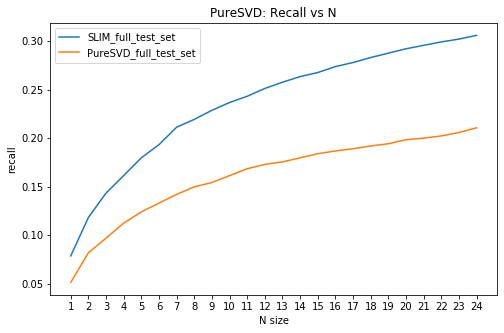

In [23]:
N_range = range(1,N_max)
plt.figure(figsize=(8,5))
plt.plot(N_range, acum_recall_data_test, label="SLIM_full_test_set")
plt.plot(N_range, acum_recall_data_test_pure_svd, label="PureSVD_full_test_set")
plt.xticks(N_range)
plt.xlabel("N size")
plt.ylabel("recall")
plt.legend()
plt.title("SLIM vs PureSVD: Recall vs N full_test_set")

Text(0.5, 1.0, 'SLIM vs PureSVD: Recall vs N T_head')

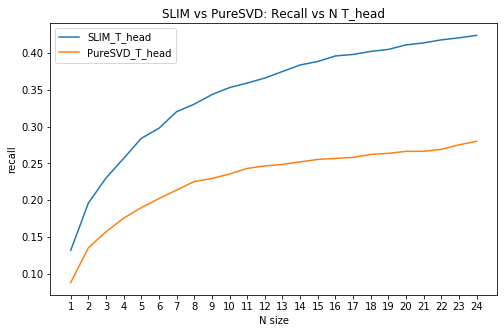

In [26]:
N_range = range(1,N_max)
plt.figure(figsize=(8,5))
plt.plot(N_range, acum_recall_T_head, label="SLIM_T_head")
plt.plot(N_range, acum_recall_T_head_pure_svd, label="PureSVD_T_head")
plt.xticks(N_range)
plt.xlabel("N size")
plt.ylabel("recall")
plt.legend()
plt.title("SLIM vs PureSVD: Recall vs N T_head")

Text(0.5, 1.0, 'SLIM vs PureSVD: Recall vs N T_long')

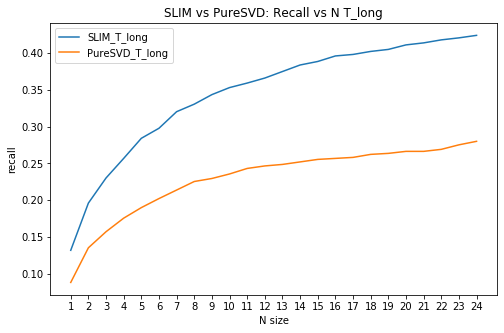

In [27]:
N_range = range(1,N_max)
plt.figure(figsize=(8,5))
plt.plot(N_range, acum_recall_T_head, label="SLIM_T_long")
plt.plot(N_range, acum_recall_T_head_pure_svd, label="PureSVD_T_long")
plt.xticks(N_range)
plt.xlabel("N size")
plt.ylabel("recall")
plt.legend()
plt.title("SLIM vs PureSVD: Recall vs N T_long")

### MAE and RMSE accuracy
As I am using diferent datasets on the algorithms I will compute SLIM and PureSVD MAE and RMSE with the 1M MovieLens dataset first. After that I will add item-based memory model, so I retrain every model again with 100k MovieLens.
Again the split on datsets will be different, I will sample 10% for testing and assuring that all test movies are in training split

In [3]:
print("Prepare data")
data_train, data_test = split_train_val_by_movie(data_1_M, assign_=assign_generator(test_size=0.1))
user_item = get_user_item(data_train)

Prepare data
Total movies 3706
Filtered movies  3043
(894550, 5)
(100942, 5)
Users: 6040
Movies: 3043


In [4]:
slim = SLIM()
slim.fit(user_item)

Training for item  500
loss  0.35925823352949793
Training for item  1000
loss  0.45406544354391654
Training for item  1500
loss  0.41673445562031414
Training for item  2000
loss  0.39499361493920415
Training for item  2500
loss  0.39145408897837997
Training for item  3000
loss  0.3752656851340595


In [5]:
slim.estimate(8,50)

1.3099195480379997

In [6]:
pure_svd = PureSVD(latent_factors=40)
pure_svd.fit(user_item)

In [7]:
pure_svd.estimate(8,50)

0.5807759491135854

In [14]:
%%time
import pdb
slim_rmse, slim_mae = evaluate_mae_rmse(slim.estimate,data_train,data_test)
print("SLIM RMSE in test: ", slim_rmse)
print("SLIM MAE in test: ", slim_mae)

SLIM RMSE in test:  2.436635048572375
SLIM MAE in test:  2.1030138429492653
CPU times: user 3min 51s, sys: 2.5 s, total: 3min 53s
Wall time: 4min 1s


In [15]:
np.array(data_test.rating.values)

array([3, 4, 5, ..., 4, 1, 3])

In [16]:
%%time
pure_svd_rmse, pure_svd_mae = evaluate_mae_rmse(pure_svd.estimate,data_train,data_test)
print("PureSVD RMSE in test: ", pure_svd_rmse)
print("PureSVD MAE in test: ", pure_svd_mae)

PureSVD RMSE in test:  2.477329507396783
PureSVD MAE in test:  2.1561379247508676
CPU times: user 49.2 s, sys: 414 ms, total: 49.6 s
Wall time: 51.8 s


Following I will add item-based model, and retrain everything with 100K

In [17]:
print("Prepare data")
data_train, data_test = split_train_val_by_movie(data_100k, assign_=assign_generator(test_size=0.1))
user_item = get_user_item(data_train)

Prepare data
Total movies 1682
Filtered movies  939
(85043, 8)
(9925, 8)
Users: 943
Movies: 939


In [18]:
knn = ItemBasedCF(knei=40)
knn.fit(data_train)
knn_rmse, knn_mae = evaluate_mae_rmse(knn.estimate,data_train,data_test)
print("KNN RMSE in test: ", knn_rmse)
print("KNN MAE in test: ", knn_mae)

KNN RMSE in test:  0.9713660749941412
KNN MAE in test:  0.7652938843577046


In [20]:
slim = SLIM()
slim.fit(user_item)
slim_rmse, slim_mae = evaluate_mae_rmse(slim.estimate,data_train,data_test)
print("SLIM RMSE in test: ", slim_rmse)
print("SLIM MAE in test: ", slim_mae)

Training for item  500
loss  0.8258845848667252
SLIM RMSE in test:  2.409477890622038
SLIM MAE in test:  2.0935827872818216


In [21]:
pure_svd = PureSVD(latent_factors=40)
pure_svd.fit(user_item)
pure_svd_rmse, pure_svd_mae = evaluate_mae_rmse(pure_svd.estimate,data_train,data_test)
print("PureSVD RMSE in test: ", pure_svd_rmse)
print("PureSVD MAE in test: ", pure_svd_mae)

PureSVD RMSE in test:  2.555399002811697
PureSVD MAE in test:  2.239953927751573


In [18]:
a = np.array([1,2,3])
b=3
np.concatenate((a,[4]))

array([1, 2, 3, 4])